In [2]:
import pandas as pd
import sklearn.metrics
import sklearn
#get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib
import collections
#import lightgbm as lgbm

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 1. Exploratory data analyses (EDA)
* Historical_sales is the weekly historical sales data for each product 
* Products contains the product information
* To_predict has the products that need demand forecasting at quarterly level

## 1.1 Load and overview of data

In [3]:
# load data as dataframe
sales_df = pd.read_csv("/Users/gege/Desktop/Yuki/study/project/demand forecasting/Historical_sales2.csv")
product_df = pd.read_csv("/Users/gege/Desktop/Yuki/study/project/demand forecasting/Product2.csv")
predict_df = pd.read_csv("/Users/gege/Desktop/Yuki/study/project/demand forecasting/Predicted_list2.csv")

In [4]:
sales_df.head(5)

,transaction_date,sku,location,quarter,sales_amt,shelf_amt
0,1/18/14,3660,GERMANY,SP2014,51,578
1,9/12/15,6159,GERMANY,FA2015,1,89
2,12/26/15,8391,GERMANY,WI2015,872,11137
3,2/6/16,8544,GERMANY,SP2016,35,121
4,7/11/15,8544,GERMANY,FA2015,0,10


In [5]:
product_df.head(5)

,sku,brand,age,formation,family,sales_price,specs
0,6336,L273,ADULT,capsule,Omega3FattyAcid,138,PATENT 5726
1,8821,G633,GRADE SCHOOL,liquid,VitaminC,42,PATENT 6776|PATENT 4090|PATENT 5726
2,12,G906,ADULT,powder,Echinacea,204,PATENT 1030
3,8658,C549,TODDLER,capsule,Calcium,26,PATENT 4533
4,1860,T484,ADULT,capsule,Cranberry,47,PATENT 4533|PATENT 6776


In [6]:
predict_df.head(5)

,sku,quarter
0,8852,SU2016
1,3403,SU2016
2,7584,SU2016
3,2057,SU2016
4,3686,SU2016


In [7]:
print(sales_df.shape, product_df.shape, predict_df.shape)

(186836, 6) (407, 7) (407, 2)


In [8]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186836 entries, 0 to 186835
Data columns (total 6 columns):
transaction_date    186836 non-null object
sku                 186836 non-null int64
location            186836 non-null object
quarter             186836 non-null object
sales_amt           186836 non-null int64
shelf_amt           186836 non-null int64
dtypes: int64(3), object(3)
memory usage: 8.6+ MB


In [9]:
sales_df.describe()

,sku,sales_amt,shelf_amt
count,186836.000000,186836.000000,186836.000000
mean,5141.013322,233.402604,3797.876587
std,2837.153943,975.852559,11400.378041
min,12.000000,0.000000,0.000000
25%,2786.000000,1.000000,15.000000
50%,4861.000000,15.000000,254.000000
75%,7685.000000,127.000000,2315.000000
max,9974.000000,103491.000000,272647.000000


In [10]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 7 columns):
sku            407 non-null int64
brand          407 non-null object
age            407 non-null object
formation      407 non-null object
family         407 non-null object
sales_price    407 non-null int64
specs          407 non-null object
dtypes: int64(2), object(5)
memory usage: 22.3+ KB


In [11]:
product_df.describe()

,sku,sales_price
count,407.000000,407.000000
mean,5185.599509,89.486486
std,2868.086609,49.101174
min,12.000000,13.000000
25%,2809.000000,54.000000
50%,4861.000000,77.000000
75%,7723.500000,115.000000
max,9974.000000,309.000000


In [12]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 2 columns):
sku        407 non-null int64
quarter    407 non-null object
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


In [13]:
predict_df.describe()

,sku
count,407.000000
mean,5185.599509
std,2868.086609
min,12.000000
25%,2809.000000
50%,4861.000000
75%,7723.500000
max,9974.000000


In [14]:
# check null value
for i in [sales_df, product_df, predict_df]:
    print(i.isnull().sum())  

transaction_date    0
sku                 0
location            0
quarter             0
sales_amt           0
shelf_amt           0
dtype: int64
sku            0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64
sku        0
quarter    0
dtype: int64


In [15]:
# check duplicates
for i in [sales_df, product_df, predict_df]:
    print(i.duplicated().sum())

1808
0
0


In [16]:
len(product_df.set_index("sku").index.get_duplicates())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """Entry point for launching an IPython kernel.


0

In [17]:
len(predict_df.set_index("sku").index.get_duplicates())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """Entry point for launching an IPython kernel.


0

* There is nut null in the three tables
* There is no duplicates in product_df and predict_df, but there are 1808 duplicate values in sales_df and we need to deal with that in the processing part.

# 1.2 Carry_over product vs. new product
 Note: product is defined by sku as instructed

* carry_over product: products having a historical data (320)
* new product: products not having historical data (87)

In [18]:
mask_co = predict_df["sku"].isin(sales_df["sku"])
print("carry_over product:",mask_co.sum())
mask_new = ~ mask_co  # ~ not
print("new product:",mask_new.sum())

carry_over product: 320
new product: 87


# 1.3 Join tables
* Join sales_df with reserve_df, and product_df. left join: only carry-over products
* new_product contains the product information of only new products

In [19]:
# aggregate pos from weekly to quarterly
#function1 = {'sales_amt':'sum', 'shelf_amt':'sum'}
sales_quarterly = sales_df.groupby(['sku','location','quarter'], as_index = False).agg("sum")

In [20]:
#之前的sales_df有duplicates， groupby之后没有duplicates
sales_quarterly.duplicated().sum()

0

In [21]:
# merge on leftjoin to get the table with products with history data
co_combine = sales_quarterly.merge(product_df, on = ["sku"], how = "left")
co_combine.head(5)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030
2,12,SPAIN,FA2015,0,12,G906,ADULT,powder,Echinacea,204,PATENT 1030
3,12,SPAIN,SP2016,0,47,G906,ADULT,powder,Echinacea,204,PATENT 1030
4,12,SPAIN,WI2015,0,32,G906,ADULT,powder,Echinacea,204,PATENT 1030


In [22]:
# merge 后要检查new table是否有null
print(co_combine.isnull().sum())

sku            0
location       0
quarter        0
sales_amt      0
shelf_amt      0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64


### What to do if you have missing values? 2% missing, 10% missing, 50% missing?

* Simple approach: using average value, but this lacks the insights of distribution of missing values
* Alternative approach: using a regression/classification model to predict and fill the missing values - chosen

In [340]:
a = product_df[predict_df["sku"].isin(sales_df["sku"])]
a.shape

(320, 7)

In [23]:
new_product = product_df[~predict_df["sku"].isin(sales_df["sku"])]
new_product.shape

(87, 7)

# 1.4. Correlation analyses
* plot linear correlation among the features
* sales_amt is the target metric and not included

In [24]:
corr = co_combine[["sales_amt", "shelf_amt", "sales_price"]].corr()
corr

,sales_amt,shelf_amt,sales_price
sales_amt,1.000000,0.891100,-0.054381
shelf_amt,0.891100,1.000000,-0.074559
sales_price,-0.054381,-0.074559,1.000000


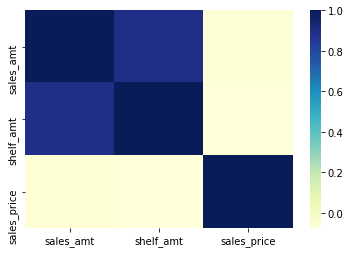

In [25]:
sns.heatmap(corr, cmap = "YlGnBu")

We could see sales_amt has positive relationship with shelf_amt, while sales_price has negative relationships with sales_amt and shelf_amt.

In [26]:
 # categorical list without specs
tmp_1 = ['location','quarter','brand','age','formation','family']
# correlation of the categorical features 
df_1 = co_combine[tmp_1]
chi_square = pd.DataFrame(abs(np.random.randn(len(tmp_1),len(tmp_1))), columns= tmp_1, index = tmp_1)

In [27]:
# cramer V statistics for correlation between categorical features
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
# method 2, cramer's V = chi2/n*min((c-1)(r-1))
#def cramers_corrected_stat1(confusion_matrix):
#    chi2 = ss.chi2_contingency(confusion_matrix)[0]
#    n = confusion_matrix.sum().sum()   
#    r,k = confusion_matrix.shape   
#    return np.sqrt(chi2/n * min( (k-1), (r-1)))

In [28]:
for i in tmp_1:
    tmp_list = [k for k in tmp_1 if k != i]
    for j in tmp_list:
        confusion_matrix = pd.crosstab(df_1[i], df_1[j])
        val = cramers_corrected_stat(confusion_matrix)
        chi_square[i][j] = float(val)
        chi_square[i][i] = 1
# chi_square is the cramer'V of all the categorical variables represents the correlations.
chi_square

,location,quarter,brand,age,formation,family
location,1.000000,0.041468,0.149061,0.076374,0.099425,0.102772
quarter,0.041468,1.000000,0.089331,0.012984,0.039609,0.065600
brand,0.149061,0.089331,1.000000,0.556071,0.645690,0.833784
age,0.076374,0.012984,0.556071,1.000000,0.306509,0.532419
formation,0.099425,0.039609,0.645690,0.306509,1.000000,0.461501
family,0.102772,0.065600,0.833784,0.532419,0.461501,1.000000


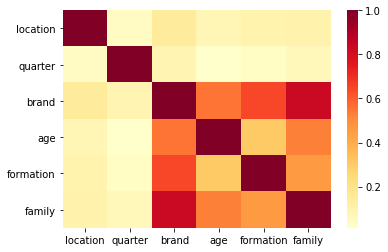

In [29]:
sns.heatmap(chi_square, cmap = "YlOrRd")

# 1.5. Glance at columns
## 1.5.1 Numerical data
See the variable itself and the relationship with y.

In [30]:
co_combine[["sales_amt", "shelf_amt", "sales_price"]].describe(percentiles = [0.25, 0.5, 0.75, 0.95]).round(2)

,sales_amt,shelf_amt,sales_price
count,6942.00,6942.00,6942.00
mean,6281.76,102215.51,88.38
std,23467.39,347800.08,49.90
min,0.00,0.00,13.00
25%,14.00,170.50,53.00
50%,247.00,3794.50,77.00
75%,2714.25,44532.00,111.00
95%,28323.80,494373.30,175.00
max,394983.00,5513126.00,306.00


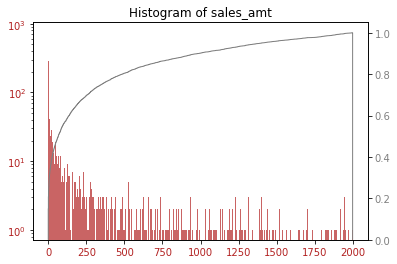

In [31]:
fig, ax1 = plt.subplots()
ax1.hist(co_combine["sales_amt"], bins = range(0, 2000), color = "firebrick", alpha = 0.7, log = True, density = False)
ax1.tick_params(labelcolor = "firebrick")
ax2 = ax1.twinx()
ax2.hist(co_combine["sales_amt"], bins = range(0, 2000), histtype = "step", color = "grey",cumulative = True, density = True)
ax2.tick_params(labelcolor = "grey")
plt.title("Histogram of sales_amt")
plt.show()

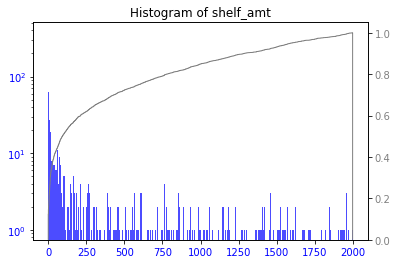

In [32]:
fig, ax1 = plt.subplots()
ax1.hist(co_combine["shelf_amt"], bins = range(0, 20000), color = "blue", alpha = 0.7, log = True, density = False)
ax1.tick_params(labelcolor = "blue")
ax2 = ax1.twinx()
ax2.hist(co_combine["shelf_amt"], bins = range(0, 20000), histtype = "step", color = "grey",cumulative = True, density = True)
ax2.tick_params(labelcolor = "grey")
plt.title("Histogram of shelf_amt")
plt.show()

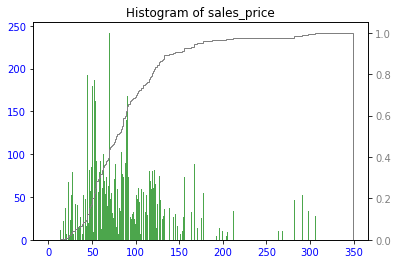

In [33]:
fig, ax1 = plt.subplots()
ax1.hist(co_combine["sales_price"], bins = range(0, 350), color = "green", alpha = 0.7, log = False, density = False)
ax1.tick_params(labelcolor = "blue")
ax2 = ax1.twinx()
ax2.hist(co_combine["sales_price"], bins = range(0, 350), histtype = "step", color = "grey",cumulative = True, density = True)
ax2.tick_params(labelcolor = "grey")
plt.title("Histogram of sales_price")
plt.show()

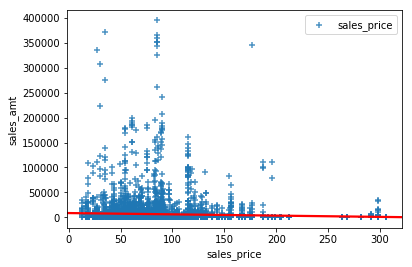

In [34]:
sns.regplot(co_combine["sales_price"], co_combine["sales_amt"], label = "sales_price", marker = "+", line_kws = {"color":"red"})
plt.legend(loc = "upper right")
plt.show()

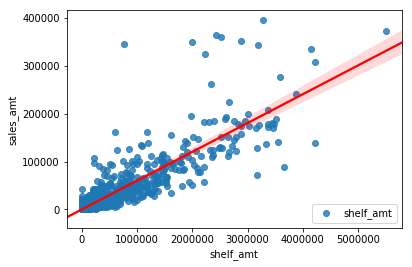

In [35]:
sns.regplot(co_combine["shelf_amt"], co_combine["sales_amt"], line_kws = {"color":"red"}, label ="shelf_amt" )
plt.legend(loc = "lower right")
plt.show()

# 1.5.2 Categorical data
* count of each category
* correlation between categorical feature with sales

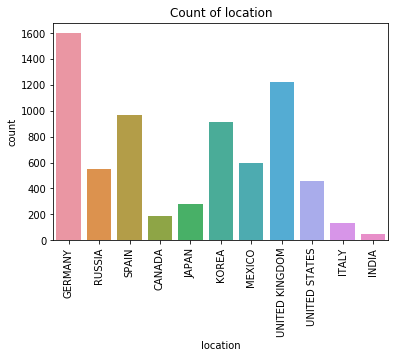

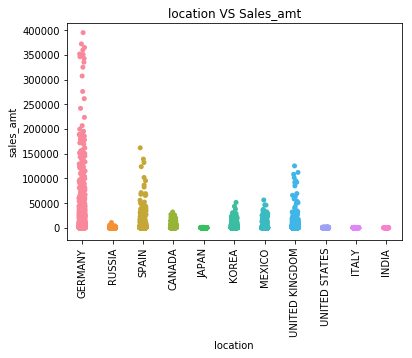

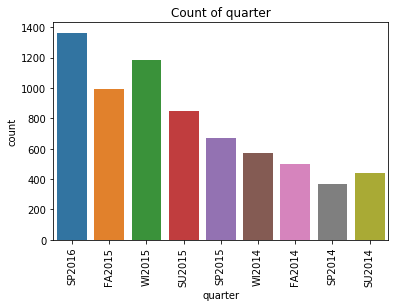

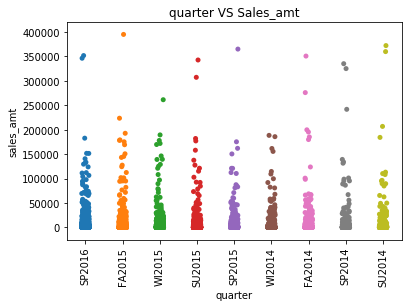

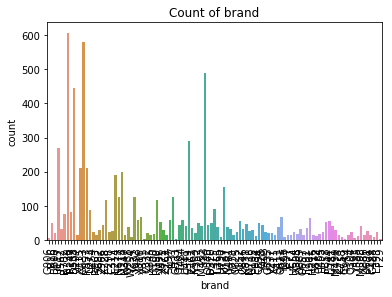

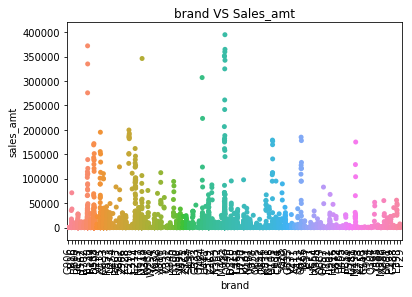

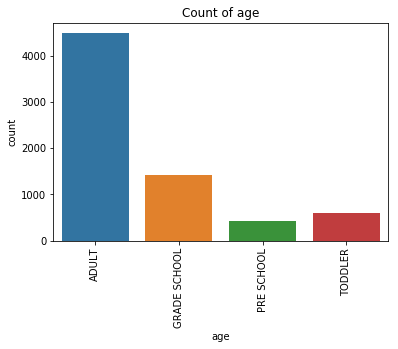

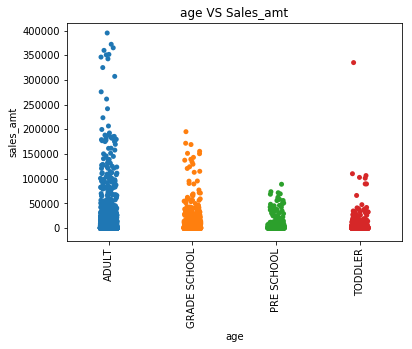

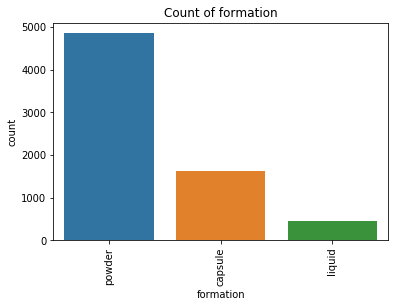

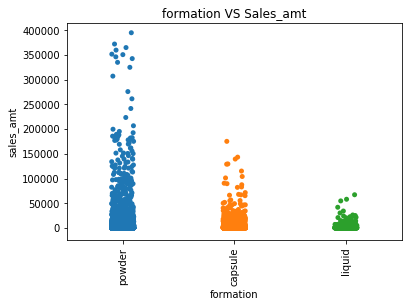

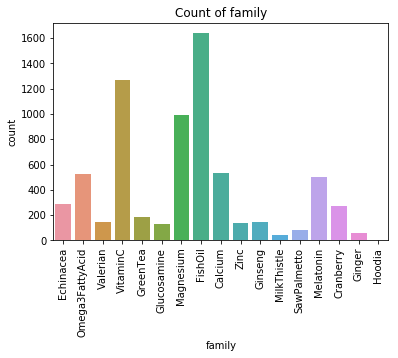

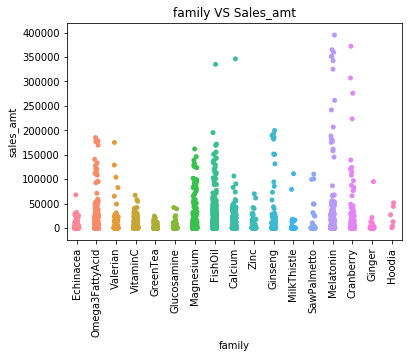

In [36]:
for i in ['location','quarter','brand','age','formation','family']:
    sns.countplot(i, data = co_combine)
    plt.xticks(rotation = 90)
    plt.title("Count of {}".format(i))
    plt.show()
    sns.stripplot(i, "sales_amt", data = co_combine, jitter = True)
    plt.title("{} VS Sales_amt".format(i))
    plt.xticks(rotation = 90)
    plt.show()

# 2. Feature processing
## 2.1 Extra features
* Extra Season and Year out of quarter
* Count # patents in a product

In [63]:
# split quarter into season and year, count number of specs
co_combine1 = co_combine.copy(deep = True)
co_combine1["season"] = co_combine1["quarter"].astype(str).str[0:2]
co_combine1["year"] = co_combine1["quarter"].str[2:6]
co_combine1["num_specs"] = co_combine1['specs'].str.split("|").str.len()
#co_combine1.drop(["quarter","specs"], axis = 1, inplace = True)
#co_combine1.head(5)

# treat specs in the same way in the new product
new_product1 = new_product.copy(deep = True)
new_product1["num_specs"] = new_product1["specs"].str.split("|").str.len()

In [64]:
co_combine1.head(5)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs,season,year,num_specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
2,12,SPAIN,FA2015,0,12,G906,ADULT,powder,Echinacea,204,PATENT 1030,FA,2015,1
3,12,SPAIN,SP2016,0,47,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
4,12,SPAIN,WI2015,0,32,G906,ADULT,powder,Echinacea,204,PATENT 1030,WI,2015,1


## 2.2 Bucktize and scaling
* bucktize sales_price
* scale numerical features

In [65]:
co_combine1["sales_price"].describe(percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

count    6942.000000
mean       88.376693
std        49.898150
min        13.000000
10%        44.000000
20%        51.000000
30%        58.000000
40%        69.000000
50%        77.000000
60%        88.600000
70%       101.000000
80%       119.000000
90%       143.000000
100%      306.000000
max       306.000000
Name: sales_price, dtype: float64

In [66]:
'''
price = [0, 30, 60, 90, 120, 150, 306]
price_range = ["price_$0-30", "price_$30-60", "price_$60-90", "price_$90-120", "price_$120-150", "price_>$150"]
price_bin = pd.cut(co_combine1["sales_price"], price, labels = price_range)
price_seg = pd.get_dummies(price_bin).astype(np.int)
co_combine1 = pd.concat([co_combine1, price_seg], axis = 1)
co_combine1.drop(["sales_price"], axis = 1, inplace = True)
'''

'\nprice = [0, 30, 60, 90, 120, 150, 306]\nprice_range = ["price_$0-30", "price_$30-60", "price_$60-90", "price_$90-120", "price_$120-150", "price_>$150"]\nprice_bin = pd.cut(co_combine1["sales_price"], price, labels = price_range)\nprice_seg = pd.get_dummies(price_bin).astype(np.int)\nco_combine1 = pd.concat([co_combine1, price_seg], axis = 1)\nco_combine1.drop(["sales_price"], axis = 1, inplace = True)\n'

In [67]:
co_combine1.head(5)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs,season,year,num_specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
2,12,SPAIN,FA2015,0,12,G906,ADULT,powder,Echinacea,204,PATENT 1030,FA,2015,1
3,12,SPAIN,SP2016,0,47,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
4,12,SPAIN,WI2015,0,32,G906,ADULT,powder,Echinacea,204,PATENT 1030,WI,2015,1


In [68]:
'''
new_product_bin = pd.cut(new_product1["sales_price"], price, labels = price_range)
new_product_seg = pd.get_dummies(new_product_bin).astype(np.int)
new_product1 = pd.concat([new_product1, new_product_seg], axis = 1)
new_product1.head(5)
'''

'\nnew_product_bin = pd.cut(new_product1["sales_price"], price, labels = price_range)\nnew_product_seg = pd.get_dummies(new_product_bin).astype(np.int)\nnew_product1 = pd.concat([new_product1, new_product_seg], axis = 1)\nnew_product1.head(5)\n'

In [69]:
# robust scaling (rubst to outliers) to numerical variables
co_combine2 = co_combine1.copy(deep = True)
scale_lst = ["sales_amt", "shelf_amt", "sales_price"]
scale = preprocessing.RobustScaler().fit(co_combine2[scale_lst])
co_combine2[scale_lst] = scale.transform(co_combine2[scale_lst])

In [70]:
# dummies categorical variables
cate_lst = ['location','brand','age','formation','family','num_specs','season','year']
co_combine2 = pd.get_dummies(co_combine2, columns = cate_lst, drop_first=True) 
co_combine2.head(5)

,sku,quarter,sales_amt,shelf_amt,sales_price,specs,location_GERMANY,location_INDIA,location_ITALY,location_JAPAN,...,num_specs_2,num_specs_3,num_specs_4,num_specs_5,num_specs_6,season_SP,season_SU,season_WI,year_2015,year_2016
0,12,SP2016,-0.091473,-0.085220,2.189655,PATENT 1030,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,12,SP2016,-0.087399,-0.084048,2.189655,PATENT 1030,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,12,FA2015,-0.091473,-0.085265,2.189655,PATENT 1030,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,12,SP2016,-0.091473,-0.084476,2.189655,PATENT 1030,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,12,WI2015,-0.091473,-0.084815,2.189655,PATENT 1030,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


# 3. Modeling
* Two models will be developed: one for carry-over products; one for new products
* The carry over model will be training on only its own historical data
* The new model will be training on the data based on similarity with the history products

## 3.1. Carry-over product model
* Use data of each product to build numerous models is not ideal, the average data point of each product/sku is 22, it is too little to build a good model
* Traditional method such as ARIMA could be used, but it lacks the 'insight' of products inner corrleation
* Build a complicated model using more products is a better option
* Target metric y = sales_amt
* SP2016 data is used to evaluate the model

In [71]:
# goup by sku, count the num of each sku, calculate the mean
co_combine2.groupby("sku").agg({"sku":"count"}).mean()
# mean is 22, and each sku has different number of iterms, it is hard to build a model for each product.

sku    21.69375
dtype: float64

In [72]:
# this dataset is special, we do not need to split train and test randomly, we just use a part 
# of data(latest) as test data.
print(max(co_combine1["year"]))
a = co_combine1[co_combine1["year"] == "2016"]
a.shape
a[a["season"] == "SP"].shape

2016


(1364, 14)

### 3.1.1 Train/test split

In [73]:
co_combine2_test = co_combine2[co_combine2["quarter"] == "SP2016"]
co_combine2_train = co_combine2[co_combine2["quarter"] != "SP2016"]
#co_combine2_test.shape
co_combine2_train.shape

(5578, 151)

In [74]:
co_combine2_test.head(2)

,sku,quarter,sales_amt,shelf_amt,sales_price,specs,location_GERMANY,location_INDIA,location_ITALY,location_JAPAN,...,num_specs_2,num_specs_3,num_specs_4,num_specs_5,num_specs_6,season_SP,season_SU,season_WI,year_2015,year_2016
0,12,SP2016,-0.091473,-0.085220,2.189655,PATENT 1030,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,12,SP2016,-0.087399,-0.084048,2.189655,PATENT 1030,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [75]:
co_combine2_train = shuffle(co_combine2_train)
co_combine2_train_x = co_combine2_train.drop(["sku", "quarter", "specs", "sales_amt"], axis = 1)
co_combine2_train_y = co_combine2_train["sales_amt"]

co_combine2_test_x = co_combine2_test.drop(["sku", "quarter", "specs", "sales_amt"], axis = 1)
co_combine2_test_y = co_combine2_test["sales_amt"]

### 3.1.2 Quick linear model for baseline
* Use Lasso regression for quick baseline
* Mean absolute percentage error (MAPE), mean absolute error (MAE), and the ratio Mean    absolute deviation (MAD) are used as evaluation metric

In [76]:
lasso = Lasso()
alphas = np.logspace(-0.8, 1.3, num = 50)
scores = np.empty_like(alphas)
opt_a = float("-inf")
max_score = float("-inf")
for i, a in enumerate(alphas):
    lasso.set_params(alpha = a)
    lasso.fit(co_combine2_train_x, co_combine2_train_y)
    scores[i] = lasso.score(co_combine2_test_x, co_combine2_test_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso

In [77]:
lasso.get_params()

{'alpha': 19.952623149688797,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

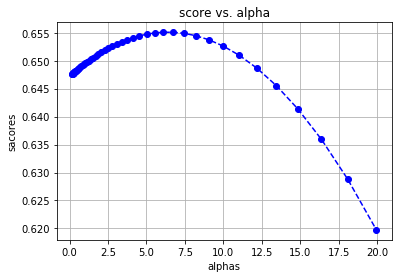

In [78]:
plt.plot(alphas, scores, color = "b", linestyle = "dashed", marker = "o")
plt.xlabel("alphas")
plt.ylabel("sacores")
plt.grid(True)
plt.title("score vs. alpha")
plt.show()

In [79]:
print(opt_a, max_score)

6.105402296585327 0.6550870510709355


In [80]:
# The final optimal lasso
lasso_f = Lasso(alpha = opt_a)
lasso_f.fit(co_combine2_train_x, co_combine2_train_y)

Lasso(alpha=6.105402296585327, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [81]:
# predict test
lasso_pred = lasso_f.predict(co_combine2_test_x)
lasso_pred

array([0.16327283, 0.16433796, 0.16394878, ..., 0.17138425, 0.19444855,
       0.1652802 ])

In [82]:
# If we treat sales_price, num_specs as numerical features, the result is almost the same.

In [83]:
co_test_lasso = co_combine2_test.copy(deep = True)
co_test_lasso["pred"] = np.round(lasso_pred, 2)
co_test_lasso["pred"] = co_test_lasso["pred"].clip(lower = 0)
co_test_lasso_agg = co_test_lasso.groupby(["sku"]).agg({"sales_amt":"sum", "pred": "sum"})
co_test_lasso_agg.head(2)

,sales_amt,pred
sku,,
12,-0.270345,0.48
37,15.648181,12.95


In [270]:
# define MAPE and MAD_ratio, and evalution result
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+1)))*100

def mean_absolute_deviation_ratio(y_true, y_pred):
    return y_pred.mad()/(y_true.mad()+0.1)

def evaluate(result_agg):
    MAPE = mean_absolute_percentage_error(result_agg["sales_amt"], result_agg["pred"])
    print("MAPE of prediction in SP2016 is {}".format(MAPE))
    MAE = mean_absolute_error(result_agg["sales_amt"], result_agg["pred"])
    print("MAE of prediction in SP2016 is {}".format(MAE))
    MAD = mean_absolute_deviation_ratio(result_agg["sales_amt"], result_agg["pred"])
    print("MAD of prediction in SP2016 is {}".format(MAD))

def plot_diff(result_agg, title1, title2):
    plt.plot(result_agg["pred"], "o", color = "red", alpha = 0.5)
    plt.plot(result_agg["sales_amt"], "*", color = "blue", alpha = 0.5)
    plt.title(title1)
    plt.legend(loc = "upper left")
    plt.show()
    
    plt.plot(result_agg["pred"] - result_agg["sales_amt"], "v", color = "green")
    plt.title(title2)
    plt.show()

In [271]:
evaluate(co_test_lasso)

MAPE of prediction in SP2016 is 28.77210753320176
MAE of prediction in SP2016 is 1.0374671177399943
MAD of prediction in SP2016 is 0.8946557346045672


In [272]:
evaluate(co_test_lasso_agg)

MAPE of prediction in SP2016 is 62.40009858011371
MAE of prediction in SP2016 is 3.7451020151100605
MAD of prediction in SP2016 is 0.8886655055486828


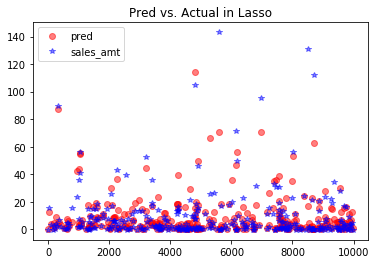

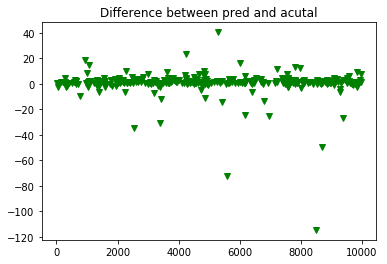

In [273]:
plot_diff(co_test_lasso_agg, 'Pred vs. Actual in Lasso', 'Difference between pred and acutal')

In [275]:
grid_1 = {"n_estimators": [35, 40, 45, 50, 55],
         "max_depth": [20, 30, 35, 40]}
rf_1 = RandomForestRegressor(random_state = 2019, verbose = 1, n_jobs = 6)
rf_1_grid = GridSearchCV(rf_1, grid_1, cv = 5)
rf_1_grid.fit(co_combine2_train_x, co_combine2_train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    3.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    3.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  3

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    4.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    3.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    4.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent wo

[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    4.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    3.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parall

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.9s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    5.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    4.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:    3.8s finished
[Parallel(n_jobs=6)]:

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    4.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    4.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed:    4.2s finished
[Parallel(n_jobs=6)]: Using backend

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=6,
                                             oob_score=False, random_state=2019,
                                             verbose=1, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [20, 30, 35, 40],
   

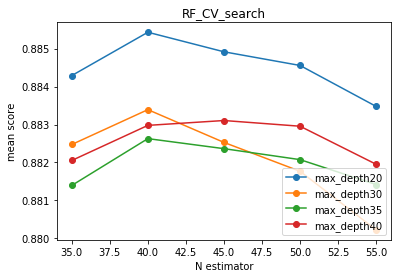

In [276]:
scores = rf_1_grid.cv_results_["mean_test_score"]
n_est = [35, 40, 45, 50, 55]
m_depth = [20, 30, 35, 40]
scores = np.array(scores).reshape(len(m_depth), len(n_est))
plt.figure()
plt.subplot(111)
for i, a in enumerate(m_depth):
    plt.plot(n_est, scores[i], marker = "o", label = "max_depth" + str(a))
plt.title("RF_CV_search")
plt.legend(loc = "lower right")
plt.xlabel("N estimator")
plt.ylabel("mean score")
plt.show()

In [277]:
print(rf_1_grid.best_params_)
print(rf_1_grid.best_score_)

{'max_depth': 20, 'n_estimators': 40}
0.8854313206723216


In [278]:
rf_best = rf_1_grid.best_estimator_
rf_best.fit(co_combine2_train_x, co_combine2_train_y)
rf_test_pred = rf_best.predict(co_combine2_test_x)
rf_test_pred

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


array([-0.09122782, -0.08005448, -0.0899973 , ..., -0.07978895,
        0.01279324, -0.08780106])

In [279]:
co_test_rf = co_combine2_test.copy(deep = True)
co_test_rf["pred"] = np.round(rf_test_pred)
co_test_rf["pred"] = co_test_rf["pred"].clip(lower = 0)

In [280]:
evaluate(co_test_rf)

MAPE of prediction in SP2016 is 22.138633014002075
MAE of prediction in SP2016 is 0.9108129447121357
MAD of prediction in SP2016 is 0.9734299693383743


In [281]:
co_test_rf_agg = co_test_rf.groupby("sku").agg({"sales_amt":"sum", "pred":"sum"})
co_test_rf_agg.head(2)

,sales_amt,pred
sku,,
12,-0.270345,0.0
37,15.648181,19.0


In [282]:
evaluate(co_test_rf_agg)

MAPE of prediction in SP2016 is 42.72596814875376
MAE of prediction in SP2016 is 3.1262941809347153
MAD of prediction in SP2016 is 0.9779689209943824


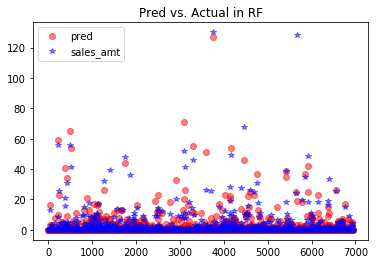

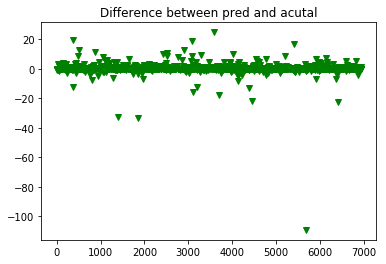

In [97]:
plot_diff(co_test_rf, 'Pred vs. Actual in RF', 'Difference between pred and acutal')

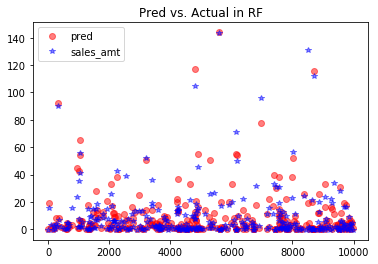

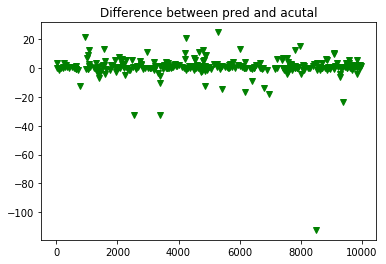

In [98]:
plot_diff(co_test_rf_agg, 'Pred vs. Actual in RF', 'Difference between pred and acutal')

In [99]:
importance_rf_best = rf_best.feature_importances_
feature_name = co_combine2_train_x.columns.tolist()
df_importantce_rf_best = pd.DataFrame({"Feature":feature_name, "Importance":importance_rf_best})
rank_importance_rf_best = df_importantce_rf_best.sort_values("Importance", ascending = False)
rank_importance_rf_best.head(2)

,Feature,Importance
0,shelf_amt,0.854985
137,num_specs_2,0.066160


In [100]:
# feature importance
def plot_feature_importance(rank_importance,left_limit, color, alpha, size_L, size_H, title):
    fig, ax = plt.subplots(1,1) 
    ax.bar(range(len(rank_importance['Feature'][0:left_limit])),rank_importance[0:left_limit]['Importance'],color=color, alpha=alpha)
    ax.set_xticks(range(rank_importance[0:left_limit].shape[0]))
    ax.set_xticklabels(rank_importance[0:left_limit]['Feature'], rotation='vertical', fontsize=12)    
    ax.set_xlabel('Features', fontsize = 16)
    ax.set_ylabel('Feature importance', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    fig.set_size_inches(size_L, size_H)
    plt.show()

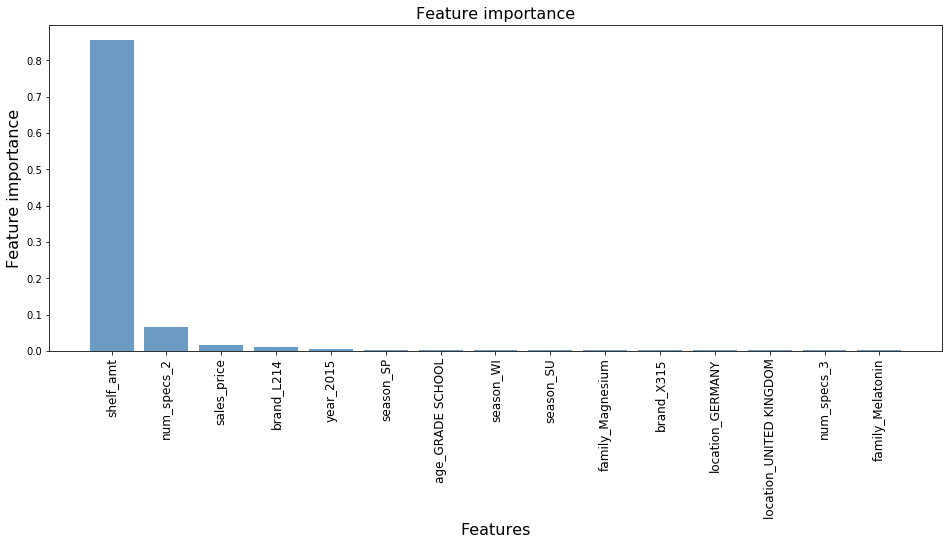

In [101]:
plot_feature_importance(rank_importance_rf_best,15, 'steelblue', 0.8, 16, 6, 'Feature importance')

In [102]:
# get the raw features importance (aggregate all dummies)
def raw_feature_importance(importance_dataframe, cate_list):
    # numercial feature importance
    numerical_importance = importance_dataframe[importance_dataframe["Feature"].isin(["shelf_amt", "sales_price"])]
    numerical_importance.reset_index(drop = True, inplace = True)

    cate_dict ={}
    for i in cate_list:
        summ = 0
        for (idx, row) in importance_dataframe.iterrows():
            if i in row.loc['Feature']:
                summ += row.loc['Importance']
        cate_dict[i] = summ 
        
    
    cate_importance = pd.DataFrame.from_dict(cate_dict, orient='index')
    cate_importance.rename(columns={0: 'Importance'}, inplace=True)
    cate_importance.reset_index(inplace = True)
    cate_importance.rename(index=str, columns={"index": "Feature"}, inplace = True)

    raw_feature_importances = pd.concat([numerical_importance, cate_importance])
    #raw_feature_importances.sort_values(by = ['Importance'], ascending = False)
    return raw_feature_importances

In [103]:
#rank_importance_rf_best[rank_importance_rf_best["Feature"].isin(["shelf_amt", "sales_price"])]

In [104]:
raw_feature_importances = raw_feature_importance(df_importantce_rf_best, cate_lst)

In [105]:
sort_raw_feature = raw_feature_importances.sort_values(by = ["Importance"], ascending = False)
sort_raw_feature

,Feature,Importance
0,shelf_amt,0.854985
5,num_specs,0.068421
1,brand,0.024629
1,sales_price,0.016805
4,family,0.009574
6,season,0.008791
0,location,0.007068
2,age,0.004382
7,year,0.003939
3,formation,0.001405


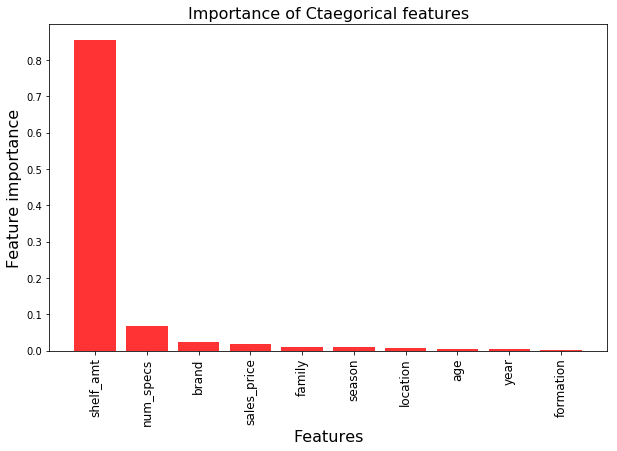

In [106]:
plot_feature_importance(sort_raw_feature, 10, "red", 0.8, 10, 6, "Importance of Ctaegorical features")

## 3.2 New product model
* The product is new and has not been sold before.
* Find a group of old products similiar to the new product, train a model on them, and use this model for prediction
* Clustering could be another method, number of clusters can be a hyper-parameter

### 3.2.1 Similar product search¶
* Analyze the cosine similarity bewteen 87 new products in new_product_1 and 320 products in co_combine_1 with full historical data
* For each new product, the top 3 most similar old products are chosen
* Then use the data of these chosen carry-over products to train a model, which can predict demand of new products
* First we choose those similar products ID by cosine value, then select products from the history data with those ID, and use them to train and test a model.

In [341]:
co_combine1.head(2)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs,season,year,num_specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030,SP,2016,1


In [286]:
new_product1.head(2)

,sku,brand,age,formation,family,sales_price,specs,num_specs
5,2778,P415,GRADE SCHOOL,powder,FishOil,77,PATENT 2876|PATENT 5726|PATENT 456,3
8,7158,C317,ADULT,powder,Zinc,229,PATENT 2876,1


In [288]:
similarity_prod = co_combine1[["sku", "brand", "age", "formation", "family", "sales_price", "num_specs"]]
cate_similarity = ["brand", "age", "formation", "family"]
similarity_prod_dummy = pd.get_dummies(similarity_prod, columns = cate_similarity, drop_first = True)
similarity_prod_dummy.duplicated().sum()

6622

In [289]:
similarity_prod_dummy.drop_duplicates(inplace = True)
similarity_prod_dummy.head(2)

,sku,sales_price,num_specs,brand_B538,brand_B800,brand_C284,brand_C317,brand_C319,brand_C332,brand_C549,...,family_GreenTea,family_Hoodia,family_Magnesium,family_Melatonin,family_MilkThistle,family_Omega3FattyAcid,family_SawPalmetto,family_Valerian,family_VitaminC,family_Zinc
0,12,204,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,37,89,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [290]:
# this is is later ID mapping
prod_ID = similarity_prod_dummy['sku']

In [292]:
s_lst = similarity_prod_dummy.drop(['sku'],axis=1).values.tolist()
len(s_lst)


320

In [293]:
new_product2 = new_product1.drop(["specs"], axis = 1)
new_prod_dummy = pd.get_dummies(new_product2, columns = cate_similarity, drop_first = True)
new_prod_dummy.head(2)

,sku,sales_price,num_specs,brand_B538,brand_B800,brand_C317,brand_C319,brand_C332,brand_C594,brand_D118,...,family_FishOil,family_Ginger,family_Ginseng,family_Magnesium,family_Melatonin,family_MilkThistle,family_Omega3FattyAcid,family_Valerian,family_VitaminC,family_Zinc
5,2778,77,3,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,7158,229,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [294]:
# change set to list
drop_set = set(new_prod_dummy.columns) - set(similarity_prod_dummy.columns)
diff_sim = list(drop_set)

# delete the columns that not in history data
if diff_sim != 0:
    new_prod_dummy.drop(diff_sim, axis = 1, inplace = True) 

In [295]:
new_prod_dummy.head(2)

,sku,sales_price,num_specs,brand_B538,brand_B800,brand_C317,brand_C319,brand_C332,brand_C594,brand_D118,...,family_FishOil,family_Ginger,family_Ginseng,family_Magnesium,family_Melatonin,family_MilkThistle,family_Omega3FattyAcid,family_Valerian,family_VitaminC,family_Zinc
5,2778,77,3,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,7158,229,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [296]:
missing_cols_sim = set(similarity_prod_dummy.columns) - set(new_prod_dummy.columns)

# Add a missing column in test set with default value equal to 0
for m in missing_cols_sim:
    new_prod_dummy[m] = 0

In [297]:
new_prod_dummy.head(2)

,sku,sales_price,num_specs,brand_B538,brand_B800,brand_C317,brand_C319,brand_C332,brand_C594,brand_D118,...,brand_J455,brand_Z966,brand_S413,brand_Z762,brand_J727,brand_H654,family_Glucosamine,brand_C621,brand_U105,brand_M598
5,2778,77,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,7158,229,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


New product table has the same columns with history product. Then we make the features in the same order

In [298]:
new_prod_dummy = new_prod_dummy[similarity_prod_dummy.columns]

In [299]:
# check duplicates, if there is duplicate, we need to get unique rows to drop duplicates.
new_prod_dummy.duplicated().sum()
#new_prod_dummy.drop_duplicates()

0

In [300]:
new_prod_ID = new_prod_dummy["sku"]

In [301]:
s_new = new_prod_dummy.drop(["sku"], axis = 1)
new = similarity_prod_dummy.drop(['sku'],axis=1)

In [302]:
print(new.shape)
print(s_new.shape)

(320, 127)
(87, 127)


In [303]:
# dataframe.values, only values will be returned
s_new_list = s_new.values.tolist()
len(s_new_list)

87

In [304]:
d_sim = defaultdict(list)
for i in range(len(new_prod_ID)):
    for j in range(len(prod_ID)):
        s_new_list[i] = np.array(s_new_list[i]).reshape(1, -1)
        s_lst[j] = np.array(s_lst[j]).reshape(1, -1)
        tmp_sim = float(cosine_similarity(s_new_list[i], s_lst[j]))
        d_sim[i].append(tmp_sim)


In [305]:
# get the top 3 most similar products list with each new product
high_sim_prod_index = set()
for ID in range(87):
    tmp_3 = sorted(range(320), key=lambda i: d_sim[ID][i])[-3:]
    for p in tmp_3:
        high_sim_prod_index.add(p)
        
high_sim_prod_ID = prod_ID.iloc[list(high_sim_prod_index)]

In [307]:
# choose the similar products from the history data
similarity_new1 = co_combine1[co_combine1["sku"].isin(high_sim_prod_ID)]
print(similarity_new1.shape)

(4098, 14)


In [308]:
similarity_new1.head(2)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs,season,year,num_specs
5,37,CANADA,FA2015,9179,93667,R16,ADULT,powder,Omega3FattyAcid,89,PATENT 5726|PATENT 4090,FA,2015,2
6,37,CANADA,SP2016,1661,7673,R16,ADULT,powder,Omega3FattyAcid,89,PATENT 5726|PATENT 4090,SP,2016,2


In [312]:
cate_lst_new = ["location", "brand", "age", "formation", "family", "season", "year"]

In [313]:
similarity_new2 = pd.get_dummies(similarity_new1, columns = cate_lst_new, drop_first = True)

In [315]:
similarity_new2.head(2)

,sku,quarter,sales_amt,shelf_amt,sales_price,specs,num_specs,location_GERMANY,location_INDIA,location_ITALY,...,family_MilkThistle,family_Omega3FattyAcid,family_Valerian,family_VitaminC,family_Zinc,season_SP,season_SU,season_WI,year_2015,year_2016
5,37,FA2015,9179,93667,89,PATENT 5726|PATENT 4090,2,0,0,0,...,0,1,0,0,0,0,0,0,1,0
6,37,SP2016,1661,7673,89,PATENT 5726|PATENT 4090,2,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [342]:
# split train and test
similarity_new2_test = similarity_new2[similarity_new2["quarter"] == "SP2016"]
similarity_new2_train = similarity_new2[similarity_new2["quarter"] != "SP2016"]

similarity_new2_train = shuffle(similarity_new2_train)
similarity_new2_train_X = similarity_new2_train.drop(["sku", "quarter", "sales_amt", "specs"], axis = 1)
similarity_new2_train_y = similarity_new2_train["sales_amt"]

similarity_new2_test_X = similarity_new2_test.drop(["sku", "quarter", "sales_amt", "specs"], axis = 1)
similarity_new2_test_y = similarity_new2_test["sales_amt"]

### 3.2.3 Random forest model

In [346]:
grid_2 = {'n_estimators': [5,10,20,30,40,50,60],
          'max_depth': [30,40,50,60,70]}

rf_2 = RandomForestRegressor(random_state=2019, verbose=1, n_jobs = 6)
grid_rf_2 = GridSearchCV(rf_2, grid_2, cv=3)
grid_rf_2.fit(similarity_new2_train_X, similarity_new2_train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_job

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_job

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    3.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.9s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  3

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    3.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    3.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  3

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=6,
                                             oob_score=False, random_state=2019,
                                             verbose=1, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [30, 40, 50, 60, 70],

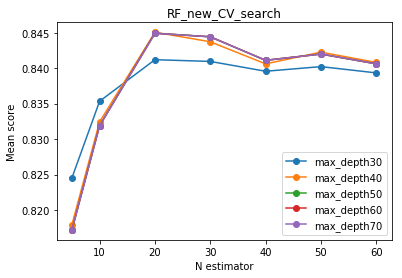

In [348]:
scores = grid_rf_2.cv_results_["mean_test_score"]
n_est = [5,10,20,30,40,50,60]
m_depth = [30,40,50,60,70]
scores = np.array(scores).reshape(len(m_depth), len(n_est))
plt.figure()
plt.subplot(111)
for i, a in enumerate(m_depth):
    plt.plot(n_est, scores[i], marker = "o", label = "max_depth" + str(a))
plt.title("RF_new_CV_search")
plt.legend(loc = "lower right")
plt.xlabel("N estimator")
plt.ylabel("Mean score")
plt.show()

In [349]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'max_depth': 40, 'n_estimators': 20}
0.8450704920807669


In [350]:
# the model with best parameters
rf_best_new = grid_rf_2.best_estimator_
rf_best_new.fit(similarity_new2_train_X, similarity_new2_train_y)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=6,
                      oob_score=False, random_state=2019, verbose=1,
                      warm_start=False)

In [351]:
test_pred = rf_best_new.predict(similarity_new2_test_X)
test_pred

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


array([4.0290000e+02, 1.9995000e+02, 2.3890000e+02, 7.4650000e+01,
       1.6500000e+00, 1.6863500e+03, 5.1495800e+04, 9.7592500e+03,
       3.7110000e+02, 6.8316000e+03, 1.2050000e+01, 6.4770000e+02,
       1.6800000e+01, 1.1050000e+01, 6.0425000e+02, 1.1310000e+02,
       1.8250000e+02, 2.5562400e+04, 1.0200000e+01, 1.8000000e+00,
       2.9120000e+02, 5.4216000e+03, 1.8150000e+01, 2.2280000e+02,
       3.8735000e+02, 4.1570000e+02, 2.6275000e+03, 3.4737500e+03,
       1.7100000e+01, 9.3749000e+03, 8.9300000e+01, 2.2550000e+02,
       4.9850000e+01, 6.4000000e+00, 7.1000000e+00, 1.0664450e+04,
       1.2170000e+02, 2.4642500e+03, 4.2000000e+00, 4.0000000e+00,
       1.1115000e+02, 5.4750000e+01, 2.0435000e+02, 8.0115000e+02,
       2.0850000e+01, 7.5000000e+00, 4.6240000e+02, 2.7282500e+03,
       4.7356500e+03, 5.6300000e+01, 6.9169500e+03, 1.2258000e+03,
       3.5710000e+02, 4.0075000e+02, 3.7500000e+00, 4.0000000e+00,
       7.8919000e+03, 3.5800000e+01, 2.8900000e+01, 3.0436000e

In [352]:
new_test_rf = similarity_new2_test.copy(deep = True)
new_test_rf["pred"] = np.round(test_pred)
new_test_rf["pred"] = new_test_rf["pred"].clip(lower = 0)

In [353]:
new_test_rf_agg = new_test_rf.groupby("sku").agg({'sales_amt':'sum', 'pred':'sum'})

In [354]:
evaluate(new_test_rf)

MAPE of prediction in SP2016 is 609.127807921119
MAE of prediction in SP2016 is 2751.605298013245
MAD of prediction in SP2016 is 1.0009639335418063


In [355]:
evaluate(new_test_rf_agg)

MAPE of prediction in SP2016 is 101.38493321142418
MAE of prediction in SP2016 is 10861.964071856288
MAD of prediction in SP2016 is 0.992378726439346


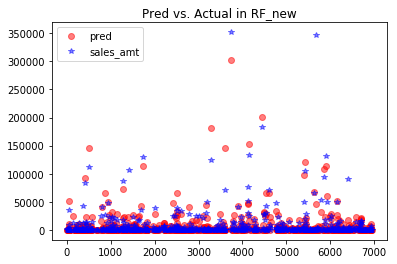

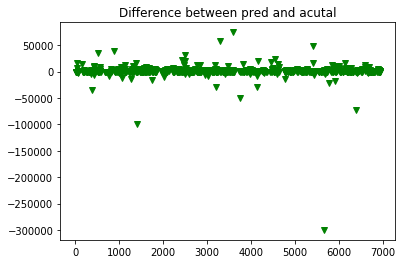

In [356]:
plot_diff(new_test_rf,'Pred vs. Actual in RF_new', 'Difference between pred and acutal')